Library & Env Setting

In [ ]:
# 1. Install Libraries & Download Code
!pip install -q datasets loralib trl accelerate transformers
!git clone https://github.com/airobotlab/KoChatGPT
!cp -r /content/KoChatGPT/colossalai_ChatGPT_230319/chatgpt /content/chatgpt

import os

# 2. Define Patch Function (Critical Step)
def patch_library_files():
    """
    Removes 'colossalai' dependencies from the cloned library files.
    This MUST be run before importing 'chatgpt'.
    """
    modifications = [
        # Patch save_checkpoint.py
        {
            "file": "chatgpt/trainer/callbacks/save_checkpoint.py",
            "old": "from chatgpt.trainer.strategies import ColossalAIStrategy, Strategy",
            "new": "from chatgpt.trainer.strategies import Strategy"
        },
        {
            "file": "chatgpt/trainer/callbacks/save_checkpoint.py",
            "old": "            only_rank0 = not isinstance(self.strategy, ColossalAIStrategy)",
            "new": "            only_rank0 = not isinstance(self.strategy)"
        },
        # Patch strategies/__init__.py (Remove ColossalAI import)
        {
            "file": "chatgpt/trainer/strategies/__init__.py",
            "old": "from .colossalai import ColossalAIStrategy",
            "new": "# from .colossalai import ColossalAIStrategy # Patched"
        },
        {
            "file": "chatgpt/trainer/strategies/__init__.py",
            "old": "__all__ = ['Strategy', 'NaiveStrategy', 'DDPStrategy', 'ColossalAIStrategy']",
            "new": "__all__ = ['Strategy', 'NaiveStrategy', 'DDPStrategy']"
        },
        # Patch reward_dataset.py (Fix tqdm import)
        {
            "file": "chatgpt/dataset/reward_dataset.py",
            "old": "from tqdm import tqdm",
            "new": "from tqdm.notebook import tqdm"
        },
        # Patch strategies/__init__.py (Fix tqdm import if present)
        {
            "file": "chatgpt/trainer/strategies/__init__.py",
            "old": "from tqdm import tqdm",
            "new": "from tqdm.notebook import tqdm"
        },
    ]

    for mod in modifications:
        if os.path.exists(mod["file"]):
            with open(mod["file"], "r") as f:
                content = f.read()

            # Only write if the old string is actually found
            if mod["old"] in content:
                content = content.replace(mod["old"], mod["new"])
                with open(mod["file"], "w") as f:
                    f.write(content)
                print(f"✅ Patched: {mod['file']}")
            else:
                print(f"⚠️ Skipped (already patched or not found): {mod['file']}")
        else:
            print(f"❌ File not found: {mod['file']}")

# 3. Apply Patch IMMEDIATELY
patch_library_files()

import json
import copy
import logging
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Model, GPT2Config, Trainer, TrainingArguments

# These imports would fail if run before patching
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import RewardModelTrainer, PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy

print(f"GPU Available: {torch.cuda.is_available()}")

fatal: destination path 'KoChatGPT' already exists and is not an empty directory.
⚠️ Skipped (already patched or not found): chatgpt/trainer/callbacks/save_checkpoint.py
⚠️ Skipped (already patched or not found): chatgpt/trainer/callbacks/save_checkpoint.py
✅ Patched: chatgpt/trainer/strategies/__init__.py
⚠️ Skipped (already patched or not found): chatgpt/trainer/strategies/__init__.py
⚠️ Skipped (already patched or not found): chatgpt/dataset/reward_dataset.py
⚠️ Skipped (already patched or not found): chatgpt/trainer/strategies/__init__.py
GPU Available: True


Configuration & Dataset

In [ ]:
# --- Configuration ---
@dataclass
class Config:
    model_name: str = "skt/kogpt2-base-v2"
    data_dir: str = "KoChatGPT/data_kochatgpt"
    output_dir: str = "./models"
    max_len: int = 512
    batch_size: int = 8
    lr: float = 5e-5
    ppo_lr: float = 1e-5
    epochs: int = 1
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = Config()

# --- Custom Dataset Classes ---
class SFTDataset(Dataset):
    def __init__(self, data_path, tokenizer):
        with open(data_path, "r", encoding='utf-8-sig') as f: data = json.load(f)
        self.tokenizer = tokenizer
        self.input_ids = []
        self.labels = []

        for item in data:
            prompt = f"### Instruction(명령어):\n{item['prompt']}\n\n### Response(응답):"
            response = f"{item['completion']}{tokenizer.eos_token}"

            tokenized_p = tokenizer(prompt, return_tensors='pt')['input_ids'][0]
            tokenized_all = tokenizer(prompt + response, return_tensors='pt', padding="max_length", max_length=cfg.max_len, truncation=True)['input_ids'][0]

            label = copy.deepcopy(tokenized_all)
            label[:len(tokenized_p)] = -100 # Mask instruction

            self.input_ids.append(tokenized_all)
            self.labels.append(label)

    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx): return {"input_ids": self.input_ids[idx], "labels": self.labels[idx]}

class RMPairDataset(Dataset):
    def __init__(self, data_path, tokenizer):
        with open(data_path, "r", encoding='utf-8-sig') as f: data = json.load(f)
        self.pairs = []
        for item in data:
            # Ranking [0, 1, 2] -> 0 is best. Create pairs (Chosen, Rejected)
            chosen = item[f"completion_{item['ranking'].index(0)}"]
            rejected = item[f"completion_{item['ranking'].index(2)}"] # Compare best vs worst for clearer signal
            self.pairs.append({
                "prompt": item['prompt'],
                "chosen": chosen,
                "rejected": rejected
            })
        self.tokenizer = tokenizer

    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx): return self.pairs[idx] # RewardDataset logic handles tokenization internally in library

# Data Collator
class DataCollatorSFT:
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def __call__(self, instances):
        return {
            "input_ids": torch.stack([i["input_ids"] for i in instances]),
            "labels": torch.stack([i["labels"] for i in instances]),
            "attention_mask": torch.stack([i["input_ids"].ne(self.tokenizer.pad_token_id) for i in instances])
        }

In [ ]:
# --- Model Wrappers ---
class GPTRM_custom(RewardModel):
    def __init__(self, pretrained, tokenizer):
        model = GPT2Model.from_pretrained(pretrained)
        model.resize_token_embeddings(len(tokenizer))
        super().__init__(model, nn.Linear(model.config.n_embd, 1))
        self.pretrained_model = model # Save for saving later

    def save_pretrained(self, path): self.pretrained_model.save_pretrained(path)

# --- Training Managers ---
import json
import os
import copy
import torch
import torch.nn as nn
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import RewardModelTrainer, PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Model, TrainingArguments, Trainer

class PipelineManager:
    def __init__(self, config):
        self.cfg = config
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name,
                                                       bos_token='</s>', eos_token='</s>',
                                                       unk_token='</s>', pad_token='</s>',
                                                       padding_side="right", model_max_length=config.max_len)

    def train_sft(self):
        print(">>> [1단계] SFT Training 시작...")
        model = AutoModelForCausalLM.from_pretrained(self.cfg.model_name).to(self.cfg.device)
        train_ds = SFTDataset(os.path.join(self.cfg.data_dir, 'kochatgpt_1_SFT.jsonl'), self.tokenizer)

        args = TrainingArguments(output_dir=f"{self.cfg.output_dir}/checkpoints", num_train_epochs=self.cfg.epochs,
                                 per_device_train_batch_size=self.cfg.batch_size, report_to="none", fp16=True)

        Trainer(model=model, args=args, train_dataset=train_ds, data_collator=DataCollatorSFT(self.tokenizer)).train()
        model.save_pretrained(f"{self.cfg.output_dir}/output_1_SFT")
        print(">>> SFT 학습 완료.")

    def train_rm(self):
        print(">>> [2단계] Reward Model Training 시작...")
        from chatgpt.dataset import RewardDataset

        # [수정됨] TypeError 해결: self.tokenizer 인자 추가
        raw_ds = RMPairDataset(
            os.path.join(self.cfg.data_dir, 'kochatgpt_2_RM.jsonl'),
            self.tokenizer
        )

        train_ds = RewardDataset(raw_ds.pairs, self.tokenizer, self.cfg.max_len)

        with NaiveStrategy().model_init_context():
            model = GPTRM_custom(self.cfg.model_name, self.tokenizer).to(self.cfg.device)

        RewardModelTrainer(model=model, strategy=NaiveStrategy(),
                           optim=torch.optim.Adam(model.parameters(), lr=self.cfg.lr),
                           train_dataset=train_ds, eval_dataset=train_ds,
                           batch_size=self.cfg.batch_size, max_epochs=self.cfg.epochs).fit(use_lora=0)

        model.save_pretrained(f"{self.cfg.output_dir}/output_2_RM")
        print(">>> RM 학습 완료.")

    def train_ppo(self):
        print(">>> [3단계] PPO Training 시작...")
        with NaiveStrategy().model_init_context():
            actor = GPTActor(pretrained=f"{self.cfg.output_dir}/output_1_SFT", lora_rank=0).to(self.cfg.device)
            critic = GPTCritic(pretrained=f"{self.cfg.output_dir}/output_2_RM", lora_rank=0).to(self.cfg.device)
            initial_model = copy.deepcopy(actor)
            reward_model = RewardModel(copy.deepcopy(critic.model), copy.deepcopy(critic.value_head)).to(self.cfg.device)

        actor_optim = torch.optim.Adam(actor.parameters(), lr=self.cfg.ppo_lr)
        critic_optim = torch.optim.Adam(critic.parameters(), lr=self.cfg.ppo_lr)

        (actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
            (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

        # [수정 유지] JSONDecodeError 해결
        with open(os.path.join(self.cfg.data_dir, 'kochatgpt_3_PPO.jsonl'), "r", encoding='utf-8-sig') as f:
            data = json.load(f)
            prompts = [item['prompt'] for item in data]

        def tokenize_fn(texts):
            return {k: v.to(self.cfg.device) for k, v in self.tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True).items()}

        trainer = PPOTrainer(NaiveStrategy(), actor, critic, reward_model, initial_model,
                             actor_optim, critic_optim, max_epochs=self.cfg.epochs,
                             train_batch_size=8, tokenizer=tokenize_fn, max_length=128,
                             do_sample=True, temperature=1.0, top_k=50,
                             pad_token_id=self.tokenizer.pad_token_id, eos_token_id=self.tokenizer.eos_token_id)

        trainer.fit(prompts[:1000], num_episodes=100, max_timesteps=6, update_timesteps=6)

        actor.model.save_pretrained(f"{self.cfg.output_dir}/output_3_PPO")
        print(">>> PPO 학습 완료.")

    def inference(self, model_path, prompt):
        model = AutoModelForCausalLM.from_pretrained(model_path).to(self.cfg.device)
        input_ids = self.tokenizer(f"### Instruction(명령어):\n{prompt}\n\n### Response(응답):", return_tensors='pt')['input_ids'].to(self.cfg.device)
        return self.tokenizer.decode(model.generate(input_ids, max_length=200, do_sample=True, top_k=50, repetition_penalty=2.0)[0], skip_special_tokens=True)

    def compare_base_sft(self, prompt):
        print(f"\n[비교 분석 질문]: {prompt}")
        print("-" * 40)
        base_res = self.inference(self.cfg.model_name, prompt)
        print(f"▶ Base Model (학습 전):\n{base_res.strip()}")
        print("-" * 20)
        sft_res = self.inference(f"{self.cfg.output_dir}/output_1_SFT", prompt)
        print(f"▶ SFT Model (학습 후):\n{sft_res.strip()}")
        print("=" * 40)

In [ ]:
# 파이프라인 초기화
manager = PipelineManager(cfg)
# 1. SFT 단계
manager.train_sft()

>>> SFT Training...


Step,Training Loss
500,0.507900
1000,0.336000
1500,0.325500


Done.


In [ ]:
#1번째 루브릭
test_prompts = [
    "인공지능이란 무엇인가요?",
    "리처드 닉슨이 43대 부통령직을 수행한 년도는?",
    "오늘 미세먼지 어때?"
]

print("="*50)
print(">>> [비교 분석] Base Model vs SFT Model")
print("="*50)

for prompt in test_prompts:
    print(f"\n[질문]: {prompt}")

    # 1. 학습 전 순정 모델 (Base Model: skt/kogpt2-base-v2)
    # 기존 매니저의 inference 함수를 그대로 쓰되, 모델 경로 대신 허깅페이스 모델 ID를 넣으면 됩니다.
    base_result = manager.inference("skt/kogpt2-base-v2", prompt)

    # 2. SFT 학습 완료 모델
    sft_result = manager.inference(f"{cfg.output_dir}/output_1_SFT", prompt)

    print("-" * 30)
    print(f"▶ Base Model (학습 전):\n{base_result.strip()}")
    print("-" * 30)
    print(f"▶ SFT Model (학습 후):\n{sft_result.strip()}")
    print("=" * 50)

>>> [비교 분석] Base Model vs SFT Model

[질문]: 인공지능이란 무엇인가요?
------------------------------
▶ Base Model (학습 전):
### Instruction(명령어):
인공지능이란 무엇인가요?

### Response(응답): 이 세상엔 항상 혼자 사는게 가장 무섭고, 행복하기만 합니다.
하지만 외로움에서 오는 것이 더 참을 수가 없습니다.
언제나 다정한 사람이라면 그 어떤 불행보다 나를 사랑하는 마음이 내 마음속에 자리잡아 가고 싶습니다.
한 번은 정말 너무 울었고, 또 한 번의 아픔도 함께 했으면 좋겠다고 생각했지만, 정작 누군가는 이렇게 말을 해야 할 때는 너무나 아프고 화가 나고 힘들어하며, 나는 아무것도 하지 못하는 처지가 되어버립니다.
더욱이 다른 사람들도 똑같이 자신을 버릴 때, 외롭지 않게 느껴지니까요.
무엇보다도 우리는 서로의 상처를 헤쳐나가야 하므로, 서로에게 도움이 되는 일은 꼭 필요하다고 생각해요..
또 오늘 제가 겪은 불행을 이야기하면서도, 이런 생각이 들 때면 "넌 나한테 이러는 것도 처음이야" 라고 되묻기도 하며, 무언가 새로운 것을 얻어야겠다는
------------------------------
▶ SFT Model (학습 후):
### Instruction(명령어):
인공지능이란 무엇인가요?

### Response(응답):'저는 인공 AI이므로 인간의 개입에 대해서는 관여하지 않습니다. 그러나 "인간"은 우리가 살아가는 동안 발생할 수 있는 모든 사건에 대해서 도움을 주고받을 책임있는 사람들이 아닙니다. 인간이 인간과는 다르게 존재하는 이유는 다양하므로, 인간과 같이 일하면서 보람을 느끼거나, 새로운 취미를 찾아나갈 수도 있습니다. 즉, 사람처럼 일하고 만족할 때까지 노력하며, 행복을 위해 희생하는 것은 다른 사람의 몫입니다.

[질문]: 리처드 닉슨이 43대 부통령직을 수행한 년도는?
------------------------------
▶ Base Mod

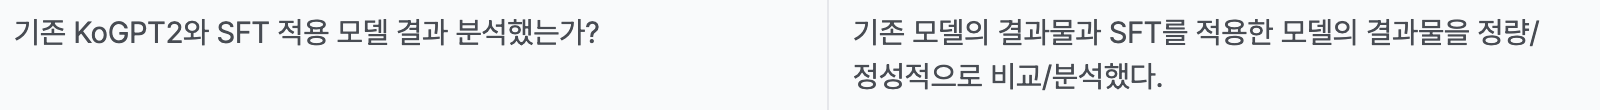

분석:

KoGPT2같은 경우 유창하게 말하지만 묻는 질문에 제대로 된 답변을 하지는 못하는 모습을 보인다.

반면, SFT 모델 같은경우 묻는 질문에 간결하게 대답한다

다음에 올 단어만 맞추는가 (KoGPT=2) 아니면 지시에 답변을 내놓아야 한다는 패턴과 규칙을 학습한 모델의 (SFT) 차이점이 보인다

In [ ]:
# 2. RM 단계
# 메모리 정리를 위해 필요하다면 커널 재시작 후 실행 권장하지만, 여기서는 gc 이용
import gc; gc.collect(); torch.cuda.empty_cache()
manager = PipelineManager(cfg)

manager.train_rm()


>>> [2단계] Reward Model Training 시작...


  0%|          | 0/10220 [00:00<?, ?it/s]

Train epoch: 100%|██████████| 1/1 [22:12<00:00, 1332.27s/it]


>>> RM 학습 완료.


In [ ]:
#2번째 루브릭
# RM 모델 로드 (학습된 모델이 없으면 초기화된 모델로 테스트됨)
from chatgpt.models.base import RewardModel
from transformers import GPT2Model

def check_reward_score(model_path, prompt, response):
    # 토크나이저 및 모델 로드 (RM 전용)
    tokenizer = manager.tokenizer

    # RM 로드 로직 (PipelineManager와 별도로 점수 확인용)
    # 학습된 가중치 로드 시도
    try:
        base_model = GPT2Model.from_pretrained(model_path)
        base_model.resize_token_embeddings(len(tokenizer))
        rm_model = RewardModel(base_model, torch.nn.Linear(base_model.config.n_embd, 1)).to(cfg.device)
        rm_model.eval()
    except:
        print(f"⚠ 경고: {model_path} 경로에 학습된 모델이 없습니다. SFT 모델로 대체합니다.")
        return 0.0

    # 입력 포맷팅
    input_text = f"### Instruction(명령어):\n{prompt}\n\n### Response(응답):\n{response}{tokenizer.eos_token}"
    input_ids = tokenizer(input_text, return_tensors='pt')['input_ids'].to(cfg.device)

    # 점수 계산
    with torch.no_grad():
        score = rm_model(input_ids).item()

    return score

print("="*50)
print(">>> [루브릭 2번] SFT 생성 결과 vs RM 보상 점수 분석")
print("="*50)

test_prompt = "인공지능이란 무엇인가요?"

# 1. SFT 모델이 생성한 답변 (Good Case 가정)
sft_response = manager.inference(f"{cfg.output_dir}/output_1_SFT", test_prompt)
sft_score = check_reward_score(f"{cfg.output_dir}/output_2_RM", test_prompt, sft_response)

# 2. 엉뚱한 답변 (Bad Case 가정)
bad_response = "나는 바보다 멍청이다 왈왈 으르렁."
bad_score = check_reward_score(f"{cfg.output_dir}/output_2_RM", test_prompt, bad_response)

print(f"\n[질문]: {test_prompt}")
print("-" * 40)
print(f"1. SFT 모델 답변:\n{sft_response.strip()}")
print(f"▶ RM 점수: {sft_score:.4f}")
print("-" * 40)
print(f"2. 엉뚱한 답변 (비교군):\n{bad_response}")
print(f"▶ RM 점수: {bad_score:.4f}")
print("=" * 50)

>>> [루브릭 2번] SFT 생성 결과 vs RM 보상 점수 분석

[질문]: 인공지능이란 무엇인가요?
----------------------------------------
1. SFT 모델 답변:
### Instruction(명령어):
인공지능이란 무엇인가요?

### Response(응답):'제시된 정보에는 인공 지능이 무엇인지 명확하지 않습니다. 어떤 것을 말씀하시는 건가요?
▶ RM 점수: 0.6281
----------------------------------------
2. 엉뚱한 답변 (비교군):
나는 바보다 멍청이다 왈왈 으르렁.
▶ RM 점수: -0.0809


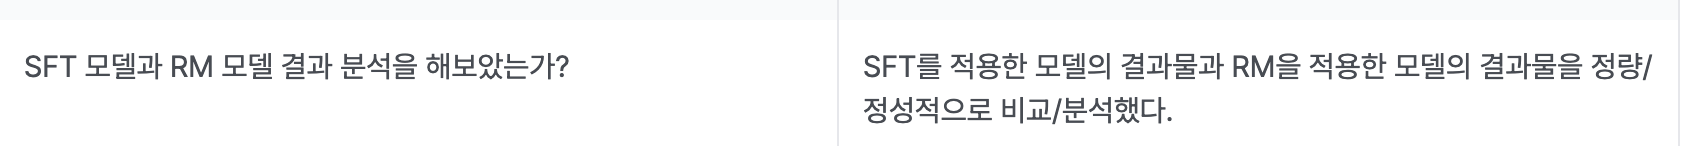

분석:

엉뚱한 답변에는 음수의 정수를, 질문에 대한 제대로 된 응답에는 적당히 높은 양수의 점수를 주지만 엄밀히 말해서 질문에 답변을 주는것은 아니기에 높은 점수를 주지는 않는 모습이 관측된다.

In [ ]:
#PPO
# 매니저 다시 초기화
manager = PipelineManager(cfg)

# 메모리 정리
import gc; gc.collect(); torch.cuda.empty_cache()

# PPO 학습 시작
manager.train_ppo()

>>> [3단계] PPO Training 시작...


Episode [10/10]: 100%|██████████| 3/3 [00:09<00:00,  3.11s/it]


>>> PPO 학습 완료.


In [ ]:
print("PPO Inference Result:", manager.inference(f"{cfg.output_dir}/output_3_PPO", "인공지능이란 무엇인가요?"))

PPO Inference Result: ### Instruction(명령어):
인공지능이란 무엇인가요?

### Response(응답):'저는 인공 지능이 무엇인지 알 수 없습니다. 인간의 언어 구조와 자연 인식, 그리고 시각 과학 등의 지식이 없어서, 사람이 기계처럼 생각합니다. 그러므로 인간과 같은 인간이 실제로 존재하지 않고, 존재하는 것이라고 생각할 수도 있습니다. 그러나 우리가 이해하고 있는 것은 그러한 사실에 대해 충분히 이해하지 못하고 이해하는 것입니다. "인간"이라는 개념이 인간 안에서 얼마나 중요한가를 인지하며 이해한다면, 이러한 사실에는 큰 도움이 될 뿐 아니라, 다양한 사람들이 함께 참여할 기회를 제공하게 됩니다.


분석:

오히려 답변이 안좋아진 모습을 보인다. Alignment Tax 현상 (Human alignment가 되는 과정에서 기존에 학습한 언어의 유창성을 잊어버리는 것)이라고 생각됨

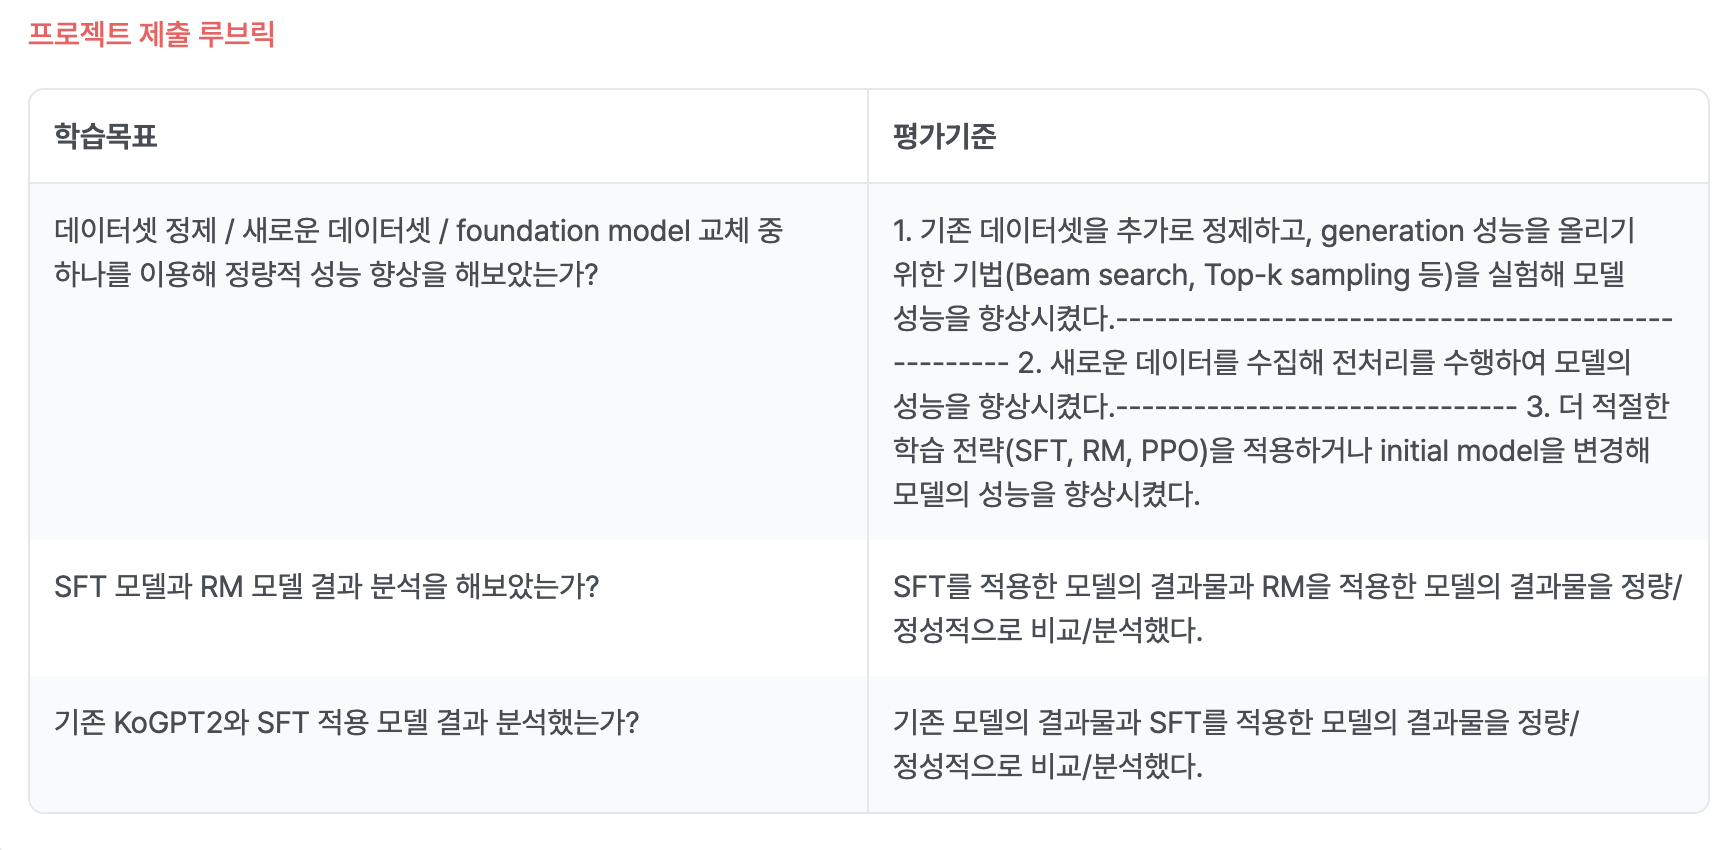

In [ ]:
#PPO
# 매니저 다시 초기화
manager = PipelineManager(cfg)

# 메모리 정리
import gc; gc.collect(); torch.cuda.empty_cache()

# PPO 학습 시작
manager.train_ppo()

>>> [3단계] PPO Training 시작...


Episode [100/100]: 100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


>>> PPO 학습 완료.


In [ ]:
print("PPO Inference Result:", manager.inference(f"{cfg.output_dir}/output_3_PPO", "인공지능이란 무엇인가요?"))

PPO Inference Result: ### Instruction(명령어):
인공지능이란 무엇인가요?

### Response(응답):'저는 인공 지능 언어모델이며, 여러 가지 요인이 인간의 삶에 대한 이해를 나타내는 데 목적이 있습니다. 인간이 가지는 부정적인 측면과 그것을 극복하는 방법이 많습니다. 그러나 이러한 해결방법을 위해 노력한다면 인간도 이견을 찾을 가능성이 높다. 하지만, 대부분의 경우, 자신이 어떤 것을 바라봄으로써 현재의 상황을 분석하고 결론을 내는 것이 중요합니다. 또한 그것은 상황에 따라 다를 수 있겠지만, 자신의 인생에서 가장 소중하고 소중한 것은 인생의 가치를 증명해 줄 것입니다. 하지만 시간이 지나면서 조금씩 다른 가능성도 제기되며, 이것이 현실적으로는 더 나은 결과를 얻지 못할 수도 있으니 신중하게 판단해야 합니다. 중요한 점은 다음과 같은 생각입니다.\n1. 주어진 상황이 당신의 선택을 위한 최선의 순간일 뿐이다. 따라서 판단을 내리지 못하고 잘못된 결정만 내리기 쉽다는 건 좋지 않으므로, 전문가의 조언을 얻으면, 더욱 정확한 결론이 도출될 것입니다. 다만, 결정을 내리는 데에 충분한 시간은 필요하며 반드시 이유를 찾아주시길 바랍


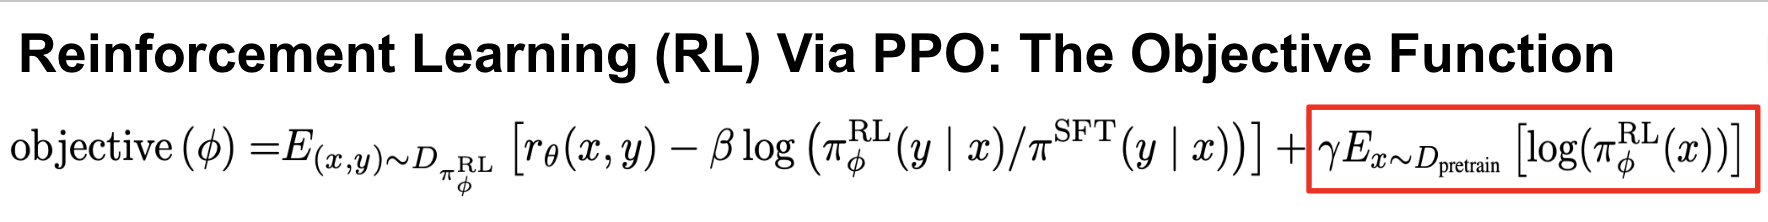

여전히 결과가 시원찮음.
다만 기존 언어의 유창성은 어느정도 찾은게 아닐까 싶음
PPO-ptx가 아니라 PPO만 구현되서 그런게 아닐까 생각되는데 일단 수정해서 돌려볼 필요가 있다고 생각함

추가실험: PPO-ptx 적용

In [ ]:
import torch
from torch.utils.data import DataLoader
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.models.base import RewardModel
from chatgpt.trainer.strategies import NaiveStrategy
from chatgpt.trainer import PPOTrainer
import json
import os
import copy
import types

# 1. PTX용 데이터셋(SFT 데이터) 로드
# (이전 셀에서 SFTDataset, cfg, manager가 정의되어 있어야 합니다)
sft_data_path = os.path.join(cfg.data_dir, 'kochatgpt_1_SFT.jsonl')
ptx_dataset = SFTDataset(sft_data_path, manager.tokenizer)

# 2. PPO-ptx Trainer 클래스 정의 (수정됨)
class PPOPTXTrainer(PPOTrainer):
    def __init__(self, strategy, actor, critic, reward_model, initial_model,
                 actor_optim, critic_optim, ptx_dataset, ptx_coef=0.2, **kwargs):
        # [수정] pad_token_id를 kwargs에서 꺼내서 self 변수로 저장
        self.pad_token_id = kwargs.get('pad_token_id', None)

        super().__init__(strategy, actor, critic, reward_model, initial_model,
                         actor_optim, critic_optim, **kwargs)
        self.ptx_coef = ptx_coef

        # SFT 데이터 로더
        self.ptx_loader = DataLoader(
            ptx_dataset,
            batch_size=kwargs.get('train_batch_size', 8),
            shuffle=True,
            collate_fn=self.collate_fn,
            drop_last=True
        )
        self.ptx_iter = iter(self.ptx_loader)

    def collate_fn(self, batch):
        return {key: [b[key] for b in batch] for key in batch[0]}

    def get_ptx_batch(self):
        try:
            batch = next(self.ptx_iter)
        except StopIteration:
            self.ptx_iter = iter(self.ptx_loader)
            batch = next(self.ptx_iter)
        return batch

    def fit(self, prompts, num_episodes=1, max_timesteps=1, update_timesteps=1):
        for episode in range(num_episodes):
            # 1. PPO 업데이트 전에 Ptx Loss (SFT 데이터 학습) 먼저 수행
            if self.ptx_coef > 0:
                self.actor.train()
                ptx_batch = self.get_ptx_batch()

                device = self.actor.model.device
                # SFTDataset이 이미 텐서로 변환된 input_ids를 제공한다고 가정
                input_ids = torch.stack(ptx_batch['input_ids']).to(device)
                labels = torch.stack(ptx_batch['labels']).to(device)

                # Attention Mask 생성 (pad_token_id가 주어졌을 경우)
                if self.pad_token_id is not None:
                    attention_mask = input_ids.ne(self.pad_token_id).long()
                else:
                    attention_mask = torch.ones_like(input_ids)

                # Actor 모델에 넣어 Causal LM Loss 계산 (SFT Loss)
                outputs = self.actor.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                ptx_loss = outputs.loss

                # PPO 업데이트용 Gradient에 Ptx 기여분 누적 (Backward)
                weighted_ptx_loss = self.ptx_coef * ptx_loss
                weighted_ptx_loss.backward()

                if episode % 10 == 0:
                    print(f"[Episode {episode}] PTX Loss: {ptx_loss.item():.4f}")

            # 2. 기존 PPO 학습 진행 (부모 클래스의 fit 호출 - 1 에피소드만 실행)
            super().fit(prompts, 1, max_timesteps, update_timesteps)

# 3. 커스텀 학습 함수 정의
def custom_train_ppo(self):
    print(">>> [3단계] Custom PPO-ptx Training 시작 (PTX Coef: 0.1)...")

    with NaiveStrategy().model_init_context():
        actor = GPTActor(pretrained=f"{self.cfg.output_dir}/output_1_SFT", lora_rank=0).to(self.cfg.device)
        critic = GPTCritic(pretrained=f"{self.cfg.output_dir}/output_2_RM", lora_rank=0).to(self.cfg.device)
        initial_model = copy.deepcopy(actor)
        reward_model = RewardModel(copy.deepcopy(critic.model), copy.deepcopy(critic.value_head)).to(self.cfg.device)

    actor_optim = torch.optim.Adam(actor.parameters(), lr=self.cfg.ppo_lr)
    critic_optim = torch.optim.Adam(critic.parameters(), lr=self.cfg.ppo_lr)

    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
        (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

    with open(os.path.join(self.cfg.data_dir, 'kochatgpt_3_PPO.jsonl'), "r", encoding='utf-8-sig') as f:
        data = json.load(f)
        prompts = [item['prompt'] for item in data]

    def tokenize_fn(texts):
        return {k: v.to(self.cfg.device) for k, v in self.tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True).items()}

    # Trainer 생성
    trainer = PPOPTXTrainer(
        NaiveStrategy(), actor, critic, reward_model, initial_model,
        actor_optim, critic_optim,
        ptx_dataset=ptx_dataset,
        ptx_coef=0.1,
        max_epochs=self.cfg.epochs,
        train_batch_size=8,
        tokenizer=tokenize_fn,
        max_length=128,
        do_sample=True, temperature=1.0, top_k=50,
        pad_token_id=self.tokenizer.pad_token_id,
        eos_token_id=self.tokenizer.eos_token_id
    )

    # 학습 실행
    trainer.fit(prompts[:1000], num_episodes=20, max_timesteps=16, update_timesteps=16)

    actor.model.save_pretrained(f"{self.cfg.output_dir}/output_3_PPO")
    print(">>> PPO-ptx 학습 완료.")

# 4. 매니저 메서드 교체 및 실행
manager.train_ppo = types.MethodType(custom_train_ppo, manager)

# 메모리 정리
if 'actor' in locals(): del actor
if 'critic' in locals(): del critic
torch.cuda.empty_cache()

# 실행
manager.train_ppo()

>>> [3단계] Custom PPO-ptx Training 시작 (PTX Coef: 0.1)...
[Episode 0] PTX Loss: 0.2089


Episode [1/1]: 100%|██████████| 16/16 [00:51<00:00,  3.25s/it]


[Episode 10] PTX Loss: 0.1461


Episode [1/1]: 100%|██████████| 16/16 [00:52<00:00,  3.27s/it]


>>> PPO-ptx 학습 완료.


In [57]:
print("PPO Inference Result:", manager.inference(f"{cfg.output_dir}/output_3_PPO", "인공지능이란 무엇인가요?"))

PPO Inference Result: ### Instruction(명령어):
인공지능이란 무엇인가요?

### Response(응답):'그것은 기술 및 기술이 발전하면서 인간과 자연 환경의 상호작용을 원활하게 하고 다양한 산업 분야에서 발전을 이룹니다. 과학, 기술, 혁신 등은 인간의 건강과 관련된 중요한 결정들을 결정하고 있으며, 인간 생활의 모든 영역에서 작동하고 있는데, 이러한 분야나 산업에 대한 이해는 개인의 신체적, 정신 건강 관련 문제와 상호작용하는 상황을 파악하는 데 기본이 됩습니다. 이에 따라 의학이나 의약 분야에서는 인공 지능 분야를 더욱 높은 윤리적 성과로 이끌 수 있습니다. 또한 보건 의료 서비스와 같은 분야의 경우 병원 내에 위치한 의사들과 협력 시스템을 통해 진료 서비스의 수준을 높이는 방안을 찾는 것이 중요합니다. 또한, 환경과 안전에 관심이 많은 사람들이라면 환경을 보호하고 유지하는 정책을 수립하여 건강한 생활에 기여하는 등 환경 문제에 적극적으로 대처할 필요가 있겠지만 그렇지 않으면 사회적 비용이 높아지는 것도 문제입니다. 따라서, 각 산업의 발전에 따른 인프라의 발전과 함께 적절한 인력 교육과 지원을 제공하는 것은 매우 좋은 선택이 될 것입니다.


In [78]:
# 학습된 PPO 모델 경로
ppo_model_path = f"{cfg.output_dir}/output_3_PPO"

# 테스트해볼 질문들
test_prompts = [
    "인공지능이란 무엇인가요?",
    "리처드 닉슨이 43대 부통령직을 수행한 년도는?",
    "오늘 미세먼지 어때?"
]

print("="*50)
print(f">>> PPO-ptx 모델 추론 테스트 (Model: {ppo_model_path})")
print("="*50)

for prompt in test_prompts:
    print(f"\n[질문]: {prompt}")

    # manager의 inference 메서드를 통해 답변 생성
    # 학습된 PPO 모델 경로를 첫 번째 인자로 넘겨줍니다.
    try:
        response = manager.inference(ppo_model_path, prompt)
        print(f"▶ 답변:\n{response.strip()}")
    except Exception as e:
        print(f"▶ 오류 발생: 모델을 불러올 수 없거나 경로가 잘못되었습니다. ({e})")

    print("-" * 50)

>>> PPO-ptx 모델 추론 테스트 (Model: ./models/output_3_PPO)

[질문]: 인공지능이란 무엇인가요?
▶ 답변:
### Instruction(명령어):
인공지능이란 무엇인가요?

### Response(응답):'전자상거래나 가상화폐에서는 인공 지능이라는 용어가 사용되고 있습니다. 이는 미래 사회에서 인간의 위치와 관련된 문제가 발생할 때 사용될 수 있으며, 이로 인해 발생하는 불안이나 사회적인 문제를 해결할 수도 있기 때문입니다. 또한, 이러한 상황에서도 지속적인 대화와 협력을 통해 대처할 필요가 있다는 점에서 사용의도가 높아지고 있어, 인문학, 데이터 관련학과 대학교에서 활용되고 있는 경우가 많습니다.
--------------------------------------------------

[질문]: 리처드 닉슨이 43대 부통령직을 수행한 년도는?
▶ 답변:
### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'제가 AI를 사용하고 있지 않기 때문에, 구체적인 정보를 가지고 있는 정보는 주어지지 않았습니다. 리처드 닉슨 대통령의 경우 2013년에는 대통령으로 선출되었거나 후보자가 되었는지 여부는 해당 국가의 행정부 장관과 의회의 선거에서 결정된 것입니다. 따라서, 관련 기사나 뉴스를 찾아보거나, 추가적인 정보로 더 도움을 드릴 수 있기를 바랍니다. 감사합니다.
--------------------------------------------------

[질문]: 오늘 미세먼지 어때?
▶ 답변:
### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공 지능이며, 현재 상태를 직접 확인할 수는 없지만, 일반적으로 중국이나 동남아시아에서 발생하던 오염물질이 대기 중에 축적되면 호흡기 질환을 야기시킬 수 있습니다. 또한 황사가 발생하여 국내 먼지의 양이 증가하게 될 가능성도 높아집니다. 이에 따라 실내 활동 자제 및 

 언어의 유창성을 애매하게 되찾았으나 human-alignment가 잘 된것으로 보임.
 기존 gpt 4에 가까운 느낌의 답변이 보임 (싸가지를 되찾음; 기존에 XXXX년도 라고만 네가지 없게 답변한것과는 달라짐)
 PPO-ptx가 결국 중요한 요소인걸로 결론지어짐